In [1]:
import numpy as np
import os
import pandas as pd
import warnings
from scipy.stats import gaussian_kde
from astropy.cosmology import WMAP9 as cosmo
from astropy.coordinates import SkyCoord
from astropy import units

import matplotlib as mpl
mpl.use('Agg')

mpl.rcParams['figure.figsize'] = (7,7)
mpl.rcParams['figure.facecolor'] = (1,1,1,1)
mpl.rcParams.update({'font.size':22})

% matplotlib inline

import matplotlib.pyplot as plt

In [2]:
import keras

Using Theano backend.


In [3]:
wdir = '/home/mho1/scratch/halo_cnn'

# Notes

 * Virial scaling: http://adsabs.harvard.edu/abs/2008ApJ...672..122E
 
 * Mass of Coma Cluster WL: ~1.88 * 10^15 M_sol/h   [ref: http://adsabs.harvard.edu/abs/2007ApJ...671.1466K]
 * Mass of Coma Cluster Vir: https://www.sciencedirect.com/science/article/pii/027510629190020X?via%3Dihub
 
### Virgo (Photometric) 
 * Virgo Survey: http://astrowww.phys.uvic.ca/~lff/NGVS/The_Data.html
 * Virgo Data: http://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/en/

# Tools

In [4]:
obj_dtype = [('z','f'),('ra','f'),('dec','f'), # raw
             ('vlos','f'), ('Rproj','f')]      # derived

In [5]:
# ~~~~~ PLOTTING ~~~~~
def plot_hist(data, n=30, label=None):
    vals, bin_edg = np.histogram(data, bins=n, density=True)
    
    plt.plot([(bin_edg[i]+bin_edg[i+1])/2. for i in range(len(bin_edg)-1)],
             vals,
             label = label
            )
    
    return vals, bin_edg

# ~~~~~ COSMOLOGY ~~~~~
def Rproj_from_radec(gals, cl):
    pos_cl = SkyCoord(ra=cl['ra']*units.deg, dec=cl['dec']*units.deg)
    pos_gal = SkyCoord(ra=gals['ra']*units.deg, dec=gals['dec']*units.deg)
    
    gal_Rproj = cosmo.kpc_proper_per_arcmin(cl['z']).value * \
                pos_gal.separation(pos_cl).arcmin / cosmo.h # [kpc/h]
    gal_Rproj /= 1000. # [Mpc/h]
    
    gals['Rproj'] = gal_Rproj
    
    return gals

def vlos_from_z(gals,cl):
    c = 299792.458  # [km/s]
    gal_vlos = c*(gals['z'] - cl['z'])/(1.0+cl['z']) # [km/s]
    
    gals['vlos'] = gal_vlos

    return gals

def add_vlos_Rproj(gals,cl):
    
    gals = vlos_from_z(gals,cl)
    gals = Rproj_from_radec(gals,cl)
    
    return gals

def logMvir(sigv):
    # ref: http://adsabs.harvard.edu/abs/2008ApJ...672..122E
    
    sigv_15 = 1082.9 # km/s
    alpha = 0.3361
    
    return np.log10((sigv/sigv_15)**(1/alpha) * 10**15)

# ~~~~ PREPROCESSING ~~~~~

def cylinder_cut(gals,cl):
    
    aperture = 1.6 # [Mpc/h]
    vcut = 2500. # [km/s]
    
    # Check for derived quantities
    if (np.sum(gals['vlos']==0)!=0) | (np.sum(gals['Rproj']==0)!=0):
        warnings.warn('Zero vlos, Rproj. Check if derived quantities have been updated.')
    
    members =(np.abs(gals['vlos']) < vcut) & (gals['Rproj'] < aperture)
    
    return gals[members]

def kde_1d(gals):
    shape = (48,1)
    bwidth = 0.25
    vcut = 2500. # [km/s]
    
    # Check for derived quantities
    if (np.sum(gals['vlos']==0)!=0):
        warnings.warn('Zero vlos. Check if derived quantities have been updated.')
    
    v_pos = np.linspace(-vcut,vcut, shape[0]+1)
    sample = [np.mean(v_pos[[i,i+1]]) for i in range(len(v_pos)-1)]
    
    kde = gaussian_kde(gals['vlos'], bwidth)
    
    kdeval = kde(sample).T
    kdeval /= kdeval.sum()
    
    return kdeval.reshape(1,*shape)

def kde_2d(gals):
    shape=(48,48)
    bwidth=0.25
    vcut = 2500. # [km/s]
    aperture = 1.6 # [Mpc/h]
    
    v_pos = np.linspace(-vcut, vcut, shape[0] + 1)
    a_pos = np.linspace(0, aperture, shape[1] + 1)
    v_pos = [np.mean(v_pos[[i,i+1]]) for i in range(len(v_pos)-1)]
    a_pos = [np.mean(a_pos[[i,i+1]]) for i in range(len(a_pos)-1)]

    mesh = np.meshgrid(a_pos,v_pos)
    mesh = np.flip(mesh,0)
    sample = np.vstack([mesh[0].ravel(), mesh[1].ravel()])
    
    
    kde = gaussian_kde((gals['vlos'],gals['Rproj']), bwidth)
    
    kdeval = np.reshape(kde(sample).T, mesh[0].shape)
    kdeval /= kdeval.sum()
    
    return kdeval.reshape(1,*shape)

# Load Trained Models

In [6]:
model_1d_num = 152
model_2d_num =  67

In [8]:
# Load keras models

model_1d = [None]*10
model_2d = [None]*10

for i in range(10):
    print('fold:',i)
    
    model_1d[i] = keras.models.load_model('/home/mho1/scratch/halo_cnn/saved_models/halo_cnn1d_r/halo_cnn1d_r_' + \
                                           str(model_1d_num)+'/models/fold_'+str(i)+'.h5')
    model_2d[i] = keras.models.load_model('/home/mho1/scratch/halo_cnn/saved_models/halo_cnn2d_r/halo_cnn2d_r_' + \
                                           str(model_2d_num)+'/models/fold_'+str(i)+'.h5')

fold: 0


/home/mho1/scratch/anaconda3/envs/jupy/lib/python3.6/site-packages/keras/engine/saving.py:327: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


fold: 1
fold: 2
fold: 3
fold: 4
fold: 5
fold: 6
fold: 7
fold: 8
fold: 9


In [16]:
# Load params

par_1d = np.load('/home/mho1/scratch/halo_cnn/saved_models/halo_cnn1d_r/halo_cnn1d_r_' + \
                 str(model_1d_num)+'/halo_cnn1d_r_' + \
                 str(model_1d_num) + '.npy',
                 encoding='latin1').item()['params']

par_2d = np.load('/home/mho1/scratch/halo_cnn/saved_models/halo_cnn2d_r/halo_cnn2d_r_' + \
                 str(model_2d_num)+'/halo_cnn2d_r_' + \
                 str(model_2d_num) + '.npy',
                 encoding='latin1').item()['params']

def logM_from_y1d(y):
    return (par_1d['logmass_max'] - par_1d['logmass_min'])*y + par_1d['logmass_min']
def logM_from_y2d(y):
    return (par_2d['logmass_max'] - par_2d['logmass_min'])*y + par_2d['logmass_min']

# Coma

In [6]:
dat_cl = pd.read_csv(os.path.join(wdir,'data_obs','coma_cluster.csv'))

print(dat_cl.columns.values)

dat_cl=dat_cl.rename(index=str,columns={'ra':'RA','dec':'DEC','z':'Z'}) # same format as RedMapper

dat_cl.head()

['ra' 'dec' 'specobjid' 'z']


,RA,DEC,specobjid,Z
0,193.97707,27.734459,7295860639766605824,2.888782
1,193.99803,28.486930,2264256514497734656,0.142809
2,193.99821,28.622316,7296075319411929088,0.511981
3,193.99900,27.955075,2522132678577252352,0.027008
4,194.09395,28.796575,7296086314528206848,0.530268


In [7]:
# Cluster center

cl = np.zeros(shape=(1,),dtype=obj_dtype)

cl['z'] = 0.0231 # wikipedia
cl['ra'] = np.mean(dat_cl['RA'])
cl['dec'] = np.mean(dat_cl['DEC'])

print('z_0:', cl['z'])
print('ra_0:', cl['ra'])
print('dec_0:', cl['dec'])

z_0: [0.0231]
ra_0: [194.87663]
dec_0: [27.924927]


In [8]:
# Galaxy sample

gals = np.zeros(shape=(len(dat_cl),), dtype=obj_dtype)

gals['z'] = dat_cl['Z']
gals['ra'] = dat_cl['RA']
gals['dec'] = dat_cl['DEC']

gals = add_vlos_Rproj(gals, cl)

gals = cylinder_cut(gals, cl)

Text(0,0.5,'dec')

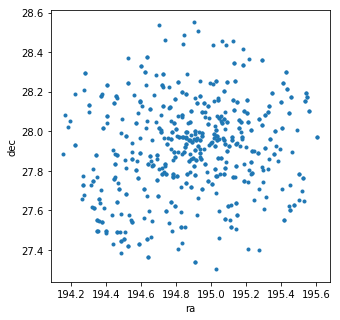

In [79]:
plt.figure(figsize=(5,5))

plt.plot(gals['ra'], gals['dec'],'.')

plt.xlabel('ra')
plt.ylabel('dec')

In [20]:
kdeval_1d = kde_1d(gals)
kdeval_2d = kde_2d(gals)

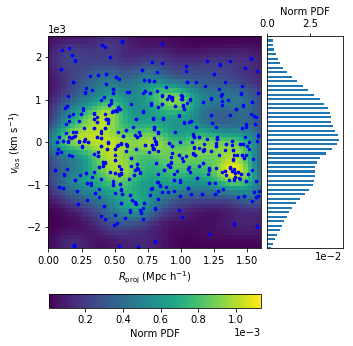

In [47]:
aperture = 1.6 # [Mpc/h]
vcut = 2500. # [km/s]

f = plt.figure(figsize=(7,5))
gs = mpl.gridspec.GridSpec(2,3, wspace=0.05,hspace=0.4, width_ratios=[1.2,2.8,1],height_ratios=[15,1])


# 2D
ax1 = f.add_subplot(gs[0,0:2])

im =ax1.imshow(kdeval_2d.reshape(48,48), aspect='auto', interpolation='nearest',
               extent=[0, aperture, -vcut, vcut])

ax1.plot(gals['Rproj'], 
         -gals['vlos'],
         'b.', markersize=5)

ax1.set_ylim(-vcut, vcut)

ax1.ticklabel_format(style='sci',axis='y', scilimits=(-1,1))
ax1.set_aspect(aspect=aperture/(2*vcut),adjustable='box', anchor='E')
ax1.set_xlabel('$R_\mathrm{proj}$ (Mpc h$^{-1}$)', fontsize=10)
ax1.set_ylabel('$v_\mathrm{los}$ (km s$^{-1}$)', fontsize=10)


# 1D
ax2 = f.add_subplot(gs[0,2])
v_pos = np.linspace(-vcut, vcut, 48)
ax2.barh(v_pos, kdeval_1d.reshape(48), height=50)

ax2.set_ylim(-vcut, vcut)

ax2.set_xlabel('Norm PDF', fontsize=10)
ax2.set_yticks([])

ax2.ticklabel_format(style='sci',axis='both', scilimits=(-1,1))
ax2.xaxis.tick_top()
ax2.xaxis.set_label_position('top')

# Colorbar
ax3 = f.add_subplot(gs[1,1])
cmap = mpl.cm.cool
norm = mpl.colors.Normalize(vmin=kdeval_2d.min(), vmax=kdeval_2d.max())

cb = mpl.colorbar.ColorbarBase(label='Norm PDF', ax=ax3, norm=norm, orientation='horizontal')
cb.set_label('Norm PDF',fontsize=10)
cb.formatter.set_powerlimits((0, 1))
cb.update_ticks()

FOLD 0 ~~ cnn1d: 15.002362 	cnn2d: 14.866888
FOLD 1 ~~ cnn1d: 15.036486 	cnn2d: 15.003866
FOLD 2 ~~ cnn1d: 14.954264 	cnn2d: 14.924338
FOLD 3 ~~ cnn1d: 15.019405 	cnn2d: 14.872398
FOLD 4 ~~ cnn1d: 14.869309 	cnn2d: 14.908662
FOLD 5 ~~ cnn1d: 14.96809 	cnn2d: 14.906006
FOLD 6 ~~ cnn1d: 15.02418 	cnn2d: 14.974466
FOLD 7 ~~ cnn1d: 15.011279 	cnn2d: 15.009808
FOLD 8 ~~ cnn1d: 14.955717 	cnn2d: 14.874715
FOLD 9 ~~ cnn1d: 14.931998 	cnn2d: 14.888759

AVG ~~ cnn1d: 14.977308 	cnn2d: 14.922991


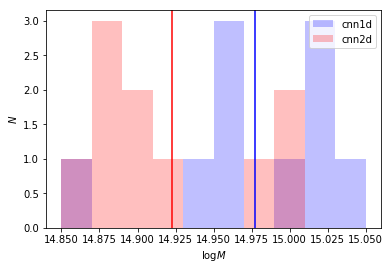

In [41]:
logM_1d = [None]*10
logM_2d = [None]*10

for i in range(10):
    logM_1d[i] = logM_from_y1d(model_1d[i].predict(kdeval_1d)).flatten()[0]
    logM_2d[i] = logM_from_y2d(model_2d[i].predict(kdeval_2d)).flatten()[0]
    
    print('FOLD', i, '~~ cnn1d:', logM_1d[i],'\tcnn2d:', logM_2d[i])
    
print('\nAVG ~~ cnn1d:', np.mean(logM_1d), '\tcnn2d:', np.mean(logM_2d))

plt.hist(logM_1d, label='cnn1d', color='b', alpha=0.25, range=(14.85,15.05))
plt.hist(logM_2d, label='cnn2d', color='r', alpha=0.25, range=(14.85,15.05))
plt.axvline(np.mean(logM_1d), color='b')
plt.axvline(np.mean(logM_2d), color='r')

plt.xlabel('$\log M$')
plt.ylabel('$N$')
plt.legend()

In [53]:
logM_Coma = np.log10(1.88*10**15)
logMvir_Coma = logMvir(np.std(gals['vlos']))

print('logM_true:', logM_Coma)
print('logM_vir_scaling:', logMvir_Coma)

logM_true: 15.27415784926368
logM_vir_scaling: 14.893618786566927


# GAMA Clusters

In [48]:
cl_files = os.listdir(os.path.join(wdir,'data_obs','clusters_arya'))
cl_files = [i for i in cl_files if i[-4:]=='.csv']

print(pd.read_csv(os.path.join(wdir, 'data_obs','clusters_arya',cl_files[0])).columns.values)

['SPECID' 'SURVEY' 'SURVEY_CODE' 'RA' 'DEC' 'WMIN' 'WMAX' 'Z' 'NQ' 'PROB'
 'FILENAME' 'URL' 'URL_IMG' 'CATAID' 'GAMA_NAME' 'IC_FLAG' 'DIST'
 'IS_SBEST' 'IS_BEST' 'NAME' 'RA_RM' 'DEC_RM' 'Z_LAMBDA' 'Z_LAMBDA_ERR'
 'LAMBDA' 'LAMBDA_ERR' 'S' 'Z_SPEC' 'OBJID' 'IMAG' 'IMAG_ERR'
 'MODEL_MAG_U' 'MODEL_MAGERR_U' 'MODEL_MAG_G' 'MODEL_MAGERR_G'
 'MODEL_MAG_R' 'MODEL_MAGERR_R' 'MODEL_MAG_I' 'MODEL_MAGERR_I'
 'MODEL_MAG_Z' 'MODEL_MAGERR_Z' 'ILUM' 'ang_sep' 'LOS_vel'
 'proper_distance']


In [59]:
ignored = 0

logM_gamma_cnn1d = []
logM_gamma_cnn2d = []
logM_gamma_vir = []

for file in cl_files:
    # print(file)
    
    dat_cl = pd.read_csv(os.path.join(wdir, 'data_obs','clusters_arya',file))

    dat_cl = dat_cl[dat_cl['Z']>0]
    
    # Cluster center
    cl = np.zeros(shape=(1,),dtype=obj_dtype)

    cl['ra'] = np.mean(dat_cl['RA'])
    cl['dec'] = np.mean(dat_cl['DEC'])
    
    if len(dat_cl['Z_SPEC'].unique()):
        cl['z'] = dat_cl['Z_SPEC'].unique()[0]
    else:
        raise Exception('multiple cl centers')
        
        
    # Galaxies
    gals = np.zeros(shape=(len(dat_cl),), dtype=obj_dtype)

    gals['z'] = dat_cl['Z']
    gals['ra'] = dat_cl['RA']
    gals['dec'] = dat_cl['DEC']

    gals = add_vlos_Rproj(gals, cl)

    gals = cylinder_cut(gals, cl)
    
    if len(gals)<10:
        ignored+=1
        continue
        
    kdeval_1d = kde_1d(gals,cl)
    kdeval_2d = kde_2d(gals,cl)
    
    logM_gamma_cnn1d.append(np.mean( [logM_from_y1d(model_1d[j].predict(kdeval_1d)).flatten()[0] \
                                      for j in range(10)] ))
    logM_gamma_cnn2d.append(np.mean( [logM_from_y2d(model_2d[j].predict(kdeval_2d)).flatten()[0] \
                                      for j in range(10)] ))
    
    logM_gamma_vir.append(logMvir(np.std(gals['vlos'])))

print('percent_removed:', ignored/len(cl_files))

/home/mho1/scratch/anaconda3/envs/jupy/lib/python3.6/site-packages/ipykernel_launcher.py:56: UserWarning: Zero vlos, Rproj. Check if derived quantities have been updated.


percent_removed: 0.47368421052631576


Text(0,0.5,'logM_pred')

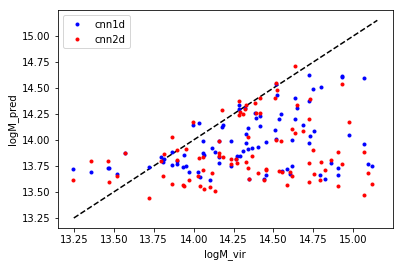

In [66]:
plt.plot(np.arange(13.25,15.25,0.1),np.arange(13.25,15.25,0.1),'k--')

plt.plot(logM_gamma_vir,logM_gamma_cnn1d,'b.', label='cnn1d')
plt.plot(logM_gamma_vir,logM_gamma_cnn2d,'r.', label='cnn2d')

plt.legend()
plt.xlabel('logM_vir')
plt.ylabel('logM_pred')

# Preprocessing

## Sample Stats, Cylinder Cut

Text(0,0.5,'dec')

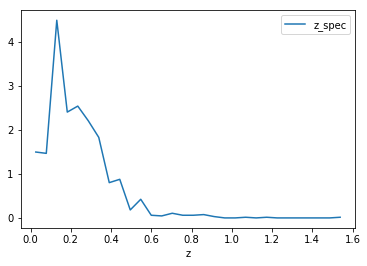

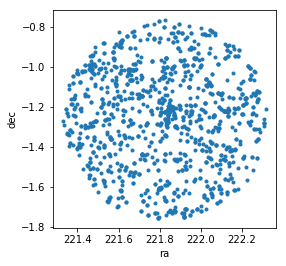

In [81]:
# p(z)



plt.figure()
x,y=plot_hist(dat_cl['Z'],label='z_spec')
plt.xlabel('z')
plt.legend()


# projected plane-of-sky
plt.figure(figsize=(4,4))
plt.plot(dat_cl['RA'],dat_cl['DEC'],'.')
plt.xlabel('ra')
plt.ylabel('dec')

In [82]:
# Calculate Rproj, vlos

c = 299792.458  # [km/s]

gal_vlos = c*(dat_cl['Z'] - cl_z)/(1.0+cl_z) # [km/s]

pos_cl = SkyCoord(ra=cl_ra*units.deg, dec=cl_dec*units.deg)
pos_gal = SkyCoord(ra=dat_cl['RA'].values*units.deg, dec=dat_cl['DEC'].values*units.deg)
gal_Rproj = cosmo.kpc_proper_per_arcmin(cl_z).value * pos_gal.separation(pos_cl).arcmin / cosmo.h # [kpc/h]
gal_Rproj /= 1000. # [Mpc/h]

gal_vlos = gal_vlos.values
# gal_Rproj = gal_Rproj.values

In [83]:
# Cylinder cut

members =(gal_vlos > -vcut) & (gal_vlos < vcut) & (gal_Rproj < aperture)
gal_vlos = gal_vlos[members]
gal_Rproj = gal_Rproj[members]

(-2500.0, 2500.0)

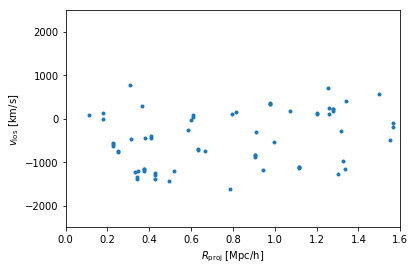

In [84]:
plt.figure()

plt.plot(gal_Rproj, gal_vlos,'.')
plt.xlabel('$R_\mathrm{proj}$ [Mpc/h]')
plt.ylabel('$v_\mathrm{los}$ [km/s]')

plt.xlim(0,aperture)
plt.ylim(-vcut,vcut)

## KDE

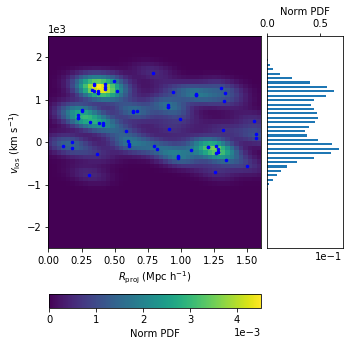

In [85]:
shape=(48,48)


#1D KDE
kde = gaussian_kde(gal_vlos, bw_method=kde_bandwidth)
v_pos = np.linspace(-vcut, vcut, shape[1] + 1)
v_pos = [np.mean(v_pos[[i,i+1]]) for i in range(len(v_pos)-1)]

kdeval_1d = kde(v_pos)
kdeval_1d = np.flip(kdeval_1d,0)/kdeval_1d.sum()


#2D KDE
a_pos = np.linspace(0, aperture, shape[0] + 1)
a_pos = [np.mean(a_pos[[i,i+1]]) for i in range(len(a_pos)-1)]

mesh = np.meshgrid(a_pos,v_pos)
mesh = np.flip(mesh,0)
sample = np.vstack([mesh[0].ravel(), mesh[1].ravel()]) # Sample at fixed intervals. Used to sample pdfs

memb = np.ndarray(shape=(2,len(gal_vlos)))
memb[0,:] = gal_vlos
memb[1,:] = gal_Rproj

# initialize a gaussian kde from galaxies
kde = gaussian_kde(memb, kde_bandwidth)

# sample kde at fixed intervals
kdeval_2d = np.reshape(kde(sample), mesh[0].shape)

# normalize input
kdeval_2d /= kdeval_2d.sum()



# plot
f = plt.figure(figsize=(7,5))
gs = mpl.gridspec.GridSpec(2,3, wspace=0.05,hspace=0.4, width_ratios=[1.2,2.8,1],height_ratios=[15,1])


# 2D
ax1 = f.add_subplot(gs[0,0:2])

im =ax1.imshow(kdeval_2d, aspect='auto', interpolation='nearest',
               extent=[0, aperture, -vcut, vcut])


ax1.plot(gal_Rproj, 
         -gal_vlos,
         'b.', markersize=5)

ax1.set_ylim(-vcut, vcut)

ax1.ticklabel_format(style='sci',axis='y', scilimits=(-1,1))
ax1.set_aspect(aspect=aperture/(2*vcut),adjustable='box', anchor='E')
# ax1.set_title('2D KDE', y=1.07)
ax1.set_xlabel('$R_\mathrm{proj}$ (Mpc h$^{-1}$)', fontsize=10)
ax1.set_ylabel('$v_\mathrm{los}$ (km s$^{-1}$)', fontsize=10)


# 1D
ax2 = f.add_subplot(gs[0,2])
ax2.barh(v_pos, kdeval_1d, height=50)

ax2.set_ylim(-vcut, vcut)

# ax2.set_title('1D KDE', y=1.07)
ax2.set_xlabel('Norm PDF', fontsize=10)
# ax2.set_ylabel('$v_{los}$ (km s$^{-1}$)', fontsize=10)
# ax2.yaxis.tick_right()
# ax2.yaxis.set_label_position('right')
ax2.set_yticks([])

ax2.ticklabel_format(style='sci',axis='both', scilimits=(-1,1))
ax2.xaxis.tick_top()
ax2.xaxis.set_label_position('top')

# Colorbar
ax3 = f.add_subplot(gs[1,1])
cmap = mpl.cm.cool
norm = mpl.colors.Normalize(vmin=kdeval_2d.min(), vmax=kdeval_2d.max())

cb = mpl.colorbar.ColorbarBase(label='Norm PDF', ax=ax3, norm=norm, orientation='horizontal')
cb.set_label('Norm PDF',fontsize=10)
cb.formatter.set_powerlimits((0, 1))
cb.update_ticks()



# plt.suptitle('$\log[M_{200c}\ ($M$_\odot h^{-1})] = $' + str(np.log10(cat.prop.loc[i,'M200c']))[0:6], fontsize=14, y=1.05)

# plt.tight_layout()

# f.savefig(os.path.join(imdir,'ex_kde.pdf'),bbox_inches='tight')

In [86]:
gal_Rproj

array([0.34209111, 1.11555182, 0.18075832, 0.6086112 , 0.90338409,
       1.27702716, 1.55290758, 1.56447674, 1.27635014, 0.90527459,
       0.34435185, 0.18051852, 1.11433057, 0.60880274, 1.30432877,
       1.27703347, 1.56500813, 0.90350422, 1.11581034, 0.34183103,
       0.79592612, 0.58715284, 0.49540845, 0.11251688, 0.94142021,
       0.30907062, 0.25230572, 0.31068956, 0.33255313, 0.51682964,
       1.25358855, 0.81691094, 0.22456653, 1.50011899, 1.33835916,
       0.59875968, 0.38002548, 0.3766731 , 1.33395674, 1.32638444,
       0.22456653, 0.3766731 , 0.63504318, 0.22456653, 0.3766731 ,
       0.63504318, 1.07288317, 0.66748004, 0.78618149, 0.36733082,
       1.26036028, 0.41036695, 0.41036695, 0.42889851, 0.97585029,
       1.26036028, 0.25272938, 0.9114728 , 1.20384182, 0.99438259,
       0.42889851, 1.31535813, 0.97585029, 0.97585029, 1.20384182,
       0.42889851])

# Load RedMapper

In [23]:
cl_files = os.listdir(os.path.join(wdir,'data_obs','clusters_arya'))
cl_files = [i for i in cl_files if i[-4:]=='.csv']

print(pd.read_csv(os.path.join(wdir, 'data_obs','clusters_arya',cl_files[0])).columns.values)

['SPECID' 'SURVEY' 'SURVEY_CODE' 'RA' 'DEC' 'WMIN' 'WMAX' 'Z' 'NQ' 'PROB'
 'FILENAME' 'URL' 'URL_IMG' 'CATAID' 'GAMA_NAME' 'IC_FLAG' 'DIST'
 'IS_SBEST' 'IS_BEST' 'NAME' 'RA_RM' 'DEC_RM' 'Z_LAMBDA' 'Z_LAMBDA_ERR'
 'LAMBDA' 'LAMBDA_ERR' 'S' 'Z_SPEC' 'OBJID' 'IMAG' 'IMAG_ERR'
 'MODEL_MAG_U' 'MODEL_MAGERR_U' 'MODEL_MAG_G' 'MODEL_MAGERR_G'
 'MODEL_MAG_R' 'MODEL_MAGERR_R' 'MODEL_MAG_I' 'MODEL_MAGERR_I'
 'MODEL_MAG_Z' 'MODEL_MAGERR_Z' 'ILUM' 'ang_sep' 'LOS_vel'
 'proper_distance']


## Duplicates

In [72]:
perc_dupl = []

for cl in cl_files[:10]:
#     print(cl)
    dat_cl = pd.read_csv(os.path.join(wdir, 'data_obs','clusters_arya',cl))
    
    perc_dupl.append(np.sum(dat_cl.duplicated(subset=['RA','DEC']))/len(dat_cl))

np.mean(perc_dupl)

0.1647744440397632

In [73]:
cl = np.random.choice(cl_files)
dat_cl = pd.read_csv(os.path.join(wdir, 'data_obs','clusters_arya',cl))

# print(dat_cl.columns.values)
# print(len(dat_cl))

# dat_cl[dat_cl.duplicated(subset=['RA','DEC'])].sort_values(['RA','DEC'])
if np.sum(dat_cl.duplicated(subset=['RA','DEC']))>0:
    i = np.random.choice(np.argwhere(dat_cl.duplicated(subset=['RA','DEC']).values).flatten())
    display(dat_cl[np.sum(dat_cl[['RA','DEC']] == dat_cl[['RA','DEC']].iloc[i].values, axis=1)>0])

,SPECID,SURVEY,SURVEY_CODE,RA,DEC,WMIN,WMAX,Z,NQ,PROB,...,MODEL_MAG_R,MODEL_MAGERR_R,MODEL_MAG_I,MODEL_MAGERR_I,MODEL_MAG_Z,MODEL_MAGERR_Z,ILUM,ang_sep,LOS_vel,proper_distance
301,G15_Y4_208_218,GAMA,5,213.42446,2.77143,3726.53,8857.58,0.70723,1,0.16,...,19.802841,0.040077,19.105967,0.033132,18.627953,0.075661,19.243595,0.45279,125199.292663,7982.430089
970,G15_Y6_098_260,GAMA,5,213.42446,2.77143,3727.88,8858.87,0.44282,4,1.00,...,19.802841,0.040077,19.105967,0.033132,18.627953,0.075661,19.243595,0.45279,59378.009770,7982.430089


## Load Single Clusters

In [79]:
cl = np.random.choice(cl_files)
dat_cl = pd.read_csv(os.path.join(wdir, 'data_obs','clusters_arya',cl))

dat_cl = dat_cl[dat_cl['Z']>0]

In [80]:
# Cluster center

if len(dat_cl['Z_SPEC'].unique()):
    cl_z = dat_cl['Z_SPEC'].unique()[0]
else:
    raise Exception('multiple cl centers')
    
cl_ra = np.mean(dat_cl['RA'])
cl_dec = np.mean(dat_cl['DEC'])

print('z_0:', cl_z)
print('ra_0:', cl_ra)
print('dec_0:', cl_dec)

z_0: 0.14816378
ra_0: 221.817547015748
dec_0: -1.2548185118110236
